# Self Play With Reward-Based Agents

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from domoku.board import GomokuBoard
from domoku.data import create_binary_rep
from domoku.rewards import InfluenceModel, RewardContext
from domoku.tools import GomokuTools as gtools
from domoku.constants import *
from dataclasses import dataclass


def print_bin(binary_sample):
    print(f'shape: {binary_sample.shape}')
    print(np.rollaxis(binary_sample, 2, 0)[0] + 2 * np.rollaxis(binary_sample, 2, 0)[1])

In [2]:
class GomokuGame:

    def __init__(self, table: 'GomokuTable', max_moves: int):
        self.table = table
        self.max_moves = max_moves
        self.board = table.board
        self.current = self.board.current_color
        self.players = table.players


    def next_move(self, show=False):
        player = self.players[self.current]
        move, terminated = player.play()
        board.set(*move)
        if show:
            board.display()
        self.current = 1 - self.current
        return terminated


In [3]:
class GomokuTable:

    def __init__(self, board: GomokuBoard):
        self.players = []
        self.board = board


    def seat(self, player: 'GomokuPlayer'):
        self.players.append(player)


    def new_game(self, max_moves: int):
        return GomokuGame(self, max_moves)


    def current_state(self):
        return create_binary_rep(self.board, padding=4, border=True)

In [4]:
class GomokuPlayer:

    def __init__(self, name: str, context: RewardContext):
        self.name = name
        self.context = context
        self.choose_from = 5


    def play(self, choose_from=None):

        # start loose, get tighter with time
        if choose_from is None:
            choose_from = self.choose_from
            self.choose_from = max(self.choose_from - 1, 1)

        board = self.context.board

        candidates = self.context.find_candidates()

        moves_by_termination = sorted([(self.context.reward(gtools.m2b((x, y), board.N))[1],
                                        tuple(gtools.m2b((x, y), size=board.N)))
                                       for _, x, y in candidates])

        if moves_by_termination[-1][0] is True:
            return moves_by_termination[-1][1], True

        moves_by_reward = sorted([(self.context.reward(gtools.m2b((x, y), board.N))[0],
                                   tuple(gtools.m2b((x, y), size=board.N)))
                                  for _, x, y in candidates])

        selectable = moves_by_reward[-choose_from:]
        #  print(f"Choosing from {selectable}")
        index = np.random.randint(0, len(selectable))
        _, move = selectable[index]
        return move, False

In [5]:
@dataclass()
class InfluenceParams:
    """
    These parameters determine the influence that various stones have on their vacant neighborhood
    """
    curr_hv_b: float
    curr_hv_f1: float
    curr_hv_f2: float
    curr_hv_f3: float
    curr_diag_b: float
    curr_diag_f1: float
    curr_diag_f2: float
    curr_diag_f3: float
    curr_tau: float

    other_hv_b: float
    other_hv_f1: float
    other_hv_f2: float
    other_hv_f3: float
    other_diag_b: float
    other_diag_f1: float
    other_diag_f2: float
    other_diag_f3: float
    other_tau: float

    offensiveness: float

    def get_current_influence(self):
        b, f1, f2, f3 = self.curr_hv_b, self.curr_hv_f1, self.curr_hv_f2, self.curr_hv_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        curr_hv = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        b, f1, f2, f3 = self.curr_diag_b, self.curr_diag_f1, self.curr_diag_f2, self.curr_diag_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        curr_diag = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        return [curr_hv, curr_diag]

    def get_other_influence(self):
        b, f1, f2, f3 = self.other_hv_b, self.other_hv_f1, self.other_hv_f2, self.other_hv_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        other_hv = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        b, f1, f2, f3 = self.other_diag_b, self.other_diag_f1, self.other_diag_f2, self.other_diag_f3
        m1, m2, m3 = np.exp(-f1/10), np.exp(-f2/10), np.exp(-f3/10)
        other_diag = [b, b*m1, b*m1*m2, b*m1*m2*m3]

        return [other_hv, other_diag]

    def get_variant(self, frac):

        return InfluenceParams(
            curr_hv_b = self.curr_hv_b * np.random.uniform(1-frac, 1+frac),
            curr_hv_f1 = self.curr_hv_f1 * np.random.uniform(1-frac, 1+frac),
            curr_hv_f2 = self.curr_hv_f2 * np.random.uniform(1-frac, 1+frac),
            curr_hv_f3 = self.curr_hv_f3 * np.random.uniform(1-frac, 1+frac),
            curr_diag_b = self.curr_diag_b * np.random.uniform(1-frac, 1+frac),
            curr_diag_f1 = self.curr_diag_f1 * np.random.uniform(1-frac, 1+frac),
            curr_diag_f2 = self.curr_diag_f2 * np.random.uniform(1-frac, 1+frac),
            curr_diag_f3 = self.curr_diag_f3 * np.random.uniform(1-frac, 1+frac),
            curr_tau = self.curr_tau * np.random.uniform(1-frac, 1+frac),

            other_hv_b = self.other_hv_b * np.random.uniform(1-frac, 1+frac),
            other_hv_f1 = self.other_hv_f1 * np.random.uniform(1-frac, 1+frac),
            other_hv_f2 = self.other_hv_f2 * np.random.uniform(1-frac, 1+frac),
            other_hv_f3 = self.other_hv_f3 * np.random.uniform(1-frac, 1+frac),
            other_diag_b = self.other_diag_b * np.random.uniform(1-frac, 1+frac),
            other_diag_f1 = self.other_diag_f1 * np.random.uniform(1-frac, 1+frac),
            other_diag_f2 = self.other_diag_f2 * np.random.uniform(1-frac, 1+frac),
            other_diag_f3 = self.other_diag_f3 * np.random.uniform(1-frac, 1+frac),
            other_tau = self.other_tau * np.random.uniform(1-frac, 1+frac),
            offensiveness=self.offensiveness * np.random.uniform(1-frac, 1+frac)
        )

params1 = InfluenceParams(.35, 1, 1, 1, .35, 1, 1, 1,
                          4.0,
                          .35, 1, 1, 1, .35, 1, 1, 1,
                          4.0,
                          .2)

params2 = params1.get_variant(.2)


In [6]:
params2

InfluenceParams(curr_hv_b=0.3308568014902375, curr_hv_f1=1.0126980661989138, curr_hv_f2=0.9428898648271321, curr_hv_f3=1.1262489416464432, curr_diag_b=0.4080161853775467, curr_diag_f1=0.9385114354282292, curr_diag_f2=1.06388606171644, curr_diag_f3=1.0229428164011132, curr_tau=4.37269486116147, other_hv_b=0.3411629215904975, other_hv_f1=0.9422945386841705, other_hv_f2=1.1327590648998724, other_hv_f3=0.9142622499472928, other_diag_b=0.36578331927944974, other_diag_f1=0.9623098437805364, other_diag_f2=0.8440104307468798, other_diag_f3=1.0217125580285051, other_tau=3.8683781009021567, offensiveness=0.21185582306493453)

In [7]:
def new_reward_model(params):
    return InfluenceModel(board_size=15,
                          current_influence=params.get_current_influence(),
                          other_influence=params.get_other_influence(),
                          curr_tau=params.curr_tau, other_tau=params.other_tau)

In [8]:
NUM_GENERATIONS = 1
NUM_GAMES = 1

In [9]:
board = None
rounds = []
for generation in range(NUM_GENERATIONS):
    print()
    print("---------------------------------------------------------------")
    print(f"   Generation  {generation + 1} ")
    print()
    print("Params 1:")
    print(params1)
    print("Params 2:")
    print(params2)
    print("---------------------------------------------------------------")

    score = []
    this_round = []
    reward1 = new_reward_model(params1)
    reward2 = new_reward_model(params2)

    table = GomokuTable(board)

    for game_no in range(NUM_GAMES):
        board = GomokuBoard(n=15, disp_width=7).set(H, 8)
        table = GomokuTable(board)
        context1 = RewardContext(board, reward1, offensiveness=params1.offensiveness)
        context2 = RewardContext(board, reward2, offensiveness=params2.offensiveness)
        player1 = GomokuPlayer('Winnie One', context1)
        player2 = GomokuPlayer('Toby Two', context2)
        table.seat(player1)
        table.seat(player2)
        game = table.new_game(max_moves=50)

        terminated = game.next_move()
        while not (terminated or len(board.stones) > board.N**2 / 2):
            terminated = game.next_move()
        # print(f"{game.players[1-board.current_color].name} wins.")
        score.append(1 - board.current_color)
        # print(f"Black: {len(score)-sum(score)} - White: {sum(score)}" )
        this_round.append(board.stones)

    rounds.append(this_round)
    print(f"Black: {len(score)-sum(score)} - White: {sum(score)}" )
    if len(score) > 2 * sum(score):
        print(f"{table.players[0].name} wins the round. Params1 cloned.")
        params2 = params1
        params1 = params1.get_variant(.2)
    else:
        print(f"{table.players[1].name} wins the round. Params2 cloned.")
        params1 = params2
        reward2 = params2.get_variant(.2)



---------------------------------------------------------------
   Generation  1 

Params 1:
InfluenceParams(curr_hv_b=0.35, curr_hv_f1=1, curr_hv_f2=1, curr_hv_f3=1, curr_diag_b=0.35, curr_diag_f1=1, curr_diag_f2=1, curr_diag_f3=1, curr_tau=4.0, other_hv_b=0.35, other_hv_f1=1, other_hv_f2=1, other_hv_f3=1, other_diag_b=0.35, other_diag_f1=1, other_diag_f2=1, other_diag_f3=1, other_tau=4.0, offensiveness=0.2)
Params 2:
InfluenceParams(curr_hv_b=0.3308568014902375, curr_hv_f1=1.0126980661989138, curr_hv_f2=0.9428898648271321, curr_hv_f3=1.1262489416464432, curr_diag_b=0.4080161853775467, curr_diag_f1=0.9385114354282292, curr_diag_f2=1.06388606171644, curr_diag_f3=1.0229428164011132, curr_tau=4.37269486116147, other_hv_b=0.3411629215904975, other_hv_f1=0.9422945386841705, other_hv_f2=1.1327590648998724, other_hv_f3=0.9142622499472928, other_diag_b=0.36578331927944974, other_diag_f1=0.9623098437805364, other_diag_f2=0.8440104307468798, other_diag_f3=1.0217125580285051, other_tau=3.868378

2022-05-04 13:59:09.135792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Black: 0 - White: 1
Toby Two wins the round. Params2 cloned.


### See the quality of the last generations

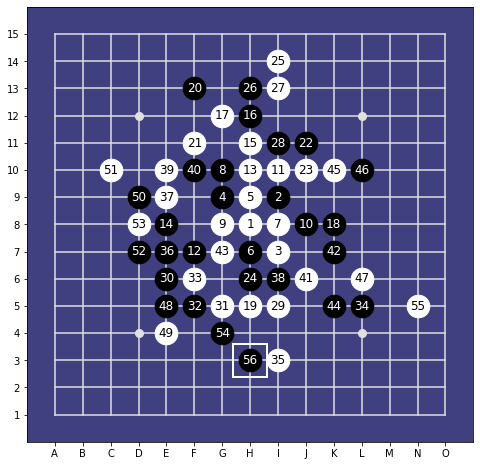

In [10]:
for i in range(NUM_GAMES):
    GomokuBoard(15, stones=rounds[-1][i], disp_width=8).display()

We can see that the lo4 threat detection didn't trigger in any of the final attacks - they did, however, apparently work in all of the intermediate attack.

It's possible that the fatal positions didn't come up as candidates in the first place. Need to debug to find that out.


Below are the boards for rapidly reproducing the failure

In [18]:
for i in range(NUM_GAMES):
    print(rounds[-1][i])

[(8, 8), (9, 7), (9, 9), (7, 7), (10, 7), (8, 6), (10, 8), (6, 8), (9, 5), (5, 9), (4, 10), (7, 5), (10, 9), (6, 4), (5, 3), (10, 6), (10, 10), (10, 11), (9, 10), (12, 10), (3, 10), (13, 11), (8, 10), (14, 12), (5, 10), (15, 13), (11, 9), (6, 10), (11, 10), (7, 10), (7, 11), (15, 14), (11, 7)]


In [21]:
gtools.stones_to_string(board.stones)

'h8g9g7i9f9h9j9i8i7j7g10d7e9f8h10i10g8i6l9d6e6e7c5d8d9c9g5g6h6k9i5h5b10f4b5e5b8b7i12e8c7g4m10k8'

# Analysis

In [23]:
stones = gtools.string_to_stones(
    'h8g8g7k11j10i9h7h9i7f7i10k7g9f10l4k5k12f12h10f5f8f13f9k10i11m12j12')

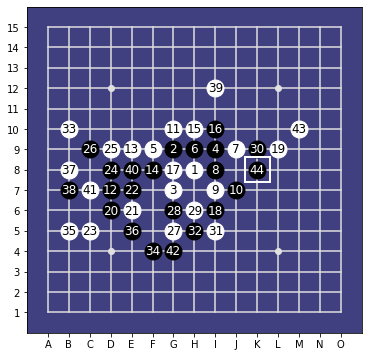

In [22]:
board = GomokuBoard(n=15, disp_width=6, stones=board.stones)
board.display()

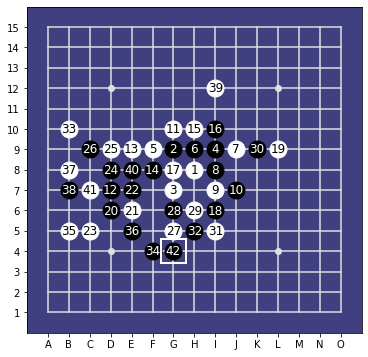

In [23]:
board.bwd(2).display()

In [24]:
board_state = create_binary_rep(board, padding=4, border=True, switch=True)

In [26]:
board_size = board.N

In [27]:
model = InfluenceModel(board_size=board_size, current_influence=[[1, 2, 4, 8], [1, 2, 4, 8]], curr_tau=2, other_tau=2)

In [28]:
context1.model.influence_of(board_state, for_humans=False)

<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.62019933e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.62019933e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.46131208e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.46131208e-06, 0.00000000e+00,
        6.77157950e-05, 0.00000000e+00, 1.23065604e-06, 1.50062488e-02,
        1.23065604e-06, 0.00000000e+00, 6.77157950e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.24930567e-07, 0.00000000e+00, 0.00000000e+00, 0.0